<a href="https://colab.research.google.com/github/NinCheon/Data_Analytics/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 1. 데이터 로드 및 결합
!pip install researchpy==0.3.2
import researchpy as rp
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from scipy import stats
from scipy.stats import norm
from scipy.stats import pointbiserialr
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

In [ ]:
# 데이터 로드
sales_data = pd.read_csv('/content/01 Sales_Data.csv')
member_data = pd.read_csv("/content/02 Member_Data.csv")

In [ ]:
# 데이터 병합
merged_data = pd.merge(sales_data, member_data, on='회원번호')
merged_data.to_csv('merged_data.csv', index=False, encoding='cp949')


In [ ]:
#데이터 확인
merged_data.describe()

,회원번호,구매수량,구매금액,사용 적립금,사용 포인트 네이버,Unnamed: 0,나이
count,2.208900e+05,220890.000000,220890.000000,220889.000000,220889.000000,220890.000000,220890.000000
mean,7.645674e+08,1.192956,11820.694146,253.995491,75.712593,5825.529798,42.700498
std,4.237322e+08,0.689067,16039.372755,1484.661511,2661.228494,3497.238037,11.372198
min,1.876416e+07,0.050000,766.000000,0.000000,0.000000,0.000000,18.000000
25%,4.196286e+08,1.000000,4212.000000,0.000000,0.000000,2811.000000,34.000000
50%,7.488013e+08,1.000000,7658.000000,0.000000,0.000000,5606.000000,40.000000
75%,1.071268e+09,1.000000,13784.000000,0.000000,0.000000,8735.000000,50.000000
max,1.670621e+09,75.000000,890203.000000,49560.000000,251600.000000,12539.000000,100.000000


#**_데이터 전처리_**


In [ ]:
#결측값 확인
merged_data.isnull().sum()

,0
회원번호,0
회원상태_x,2
구매수량,0
구매금액,0
주문일시,0
배송시작일,30635
배송완료일,30635
사용 적립금,0
사용 포인트 네이버,0
주문취소여부,637476


**# 변수 선택**

```{markdown}
# 필요한 변수만 선택하기
- 회원번호, 구매수량, 구매금액, 주문일시, 배송시작일,배송완료일, 주문취소여부,성별,나이,결혼,등록카드,구독여부

```

In [ ]:
data = merged_data[['회원번호','회원상태_x','구매수량','구매금액', '주문일시', '배송시작일','배송완료일', '주문취소여부','성별','나이','결혼','등록카드','구독여부']]
data.isnull().sum()

,0
회원번호,0
회원상태_x,2
구매수량,0
구매금액,0
주문일시,0
배송시작일,30635
배송완료일,30635
주문취소여부,637476
성별,2
나이,0


> 데이터의 컬럼명을
>
> 영어로 바꿔준다.
>
>`회원번호` : _Use_ID_
>
>`회원상태` : _Use_Stat_
>
>`구매수량` : _Buy_Volume_
>
>`구매금액` : _Buy_Price_
>
>`주문일시` : _Order_Date_
>
>`배송시작일` : _Deliv_Start_
>
>`배송완료일` : _Deliv_End_
>
>`배송기간` : _Deliv_Period_
>
>`주문취소여부` : _Order_Cancel_
>
>`성별` : _Sex_
>
>`나이` : _Age_
>
>`결혼` : _Marriage_
>
>`등록카드` : _Reg_Card_
>
>`구독여부` : _Sub_YN_
>
>`이탈기간` : _Bounce_Date_

In [ ]:
data = data.rename(columns={'회원번호':'Use_ID','회원상태_x':'Use_Stat','구매수량':'Buy_Volume','구매금액':'Buy_Price','주문일시':'Order_Date','배송시작일':'Deliv_Start','배송완료일':'Deliv_End','주문취소여부':'Order_Cancel','성별':'Sex','나이':'Age','결혼':'Marriage','등록카드':'Reg_Card','구독여부':'Sub_YN'})
data.head()

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Deliv_Start,Deliv_End,Order_Cancel,Sex,Age,Marriage,Reg_Card,Sub_YN
0,1032097472,정상회원,1.0,7083,2021.1.2,NaN,NaN,주문취소,여,39,기혼,우리은행,NaN
1,1032097472,정상회원,1.0,29865,2021.1.2,2021.1.2,2021.1.2,NaN,여,39,기혼,우리은행,NaN
2,1032097472,정상회원,1.0,23164,2021.1.2,2021.1.2,2021.1.3,NaN,여,39,기혼,우리은행,NaN
3,369152832,정상회원,1.0,16655,2021.1.2,2021.1.2,2021.1.3,NaN,여,40,기혼,농협중앙회,False
4,1032097472,정상회원,1.0,8423,2021.1.2,NaN,NaN,주문취소,여,39,기혼,우리은행,NaN


In [ ]:
# 배송 종료일에서 배송 시작을을 빼서 배송 기간 컬럼을 추가한다
data['Deliv_Period'] = (pd.to_datetime(data['Deliv_End']) - pd.to_datetime(data['Deliv_Start'])).dt.days
data.head()

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Deliv_Start,Deliv_End,Order_Cancel,Sex,Age,Marriage,Reg_Card,Sub_YN,Deliv_Period
0,1032097472,정상회원,1.0,7083,2021.1.2,NaN,NaN,주문취소,여,39,기혼,우리은행,NaN,NaN
1,1032097472,정상회원,1.0,29865,2021.1.2,2021.1.2,2021.1.2,NaN,여,39,기혼,우리은행,NaN,0.0
2,1032097472,정상회원,1.0,23164,2021.1.2,2021.1.2,2021.1.3,NaN,여,39,기혼,우리은행,NaN,1.0
3,369152832,정상회원,1.0,16655,2021.1.2,2021.1.2,2021.1.3,NaN,여,40,기혼,농협중앙회,False,1.0
4,1032097472,정상회원,1.0,8423,2021.1.2,NaN,NaN,주문취소,여,39,기혼,우리은행,NaN,NaN


In [ ]:
# NaN이 아닌, Deliv_Period 컬럼의 로우의 수와 Order_CanCel 컬럼의 로우의 수를 합한 값이 데이터 총 로우의 수와 같은지 확인한다.
print(data[data['Deliv_Period'].notnull()]['Deliv_Period'].count() + data[data['Order_Cancel'].notnull()]['Order_Cancel'].count())
print(data['Use_ID'].count())
# 결국 배송 관련 컬럼에서의 NaN은 주문취소를 의미한다.
# Deliv_Start와 Deliv_End 컬럼을 탈락시킨다.
data = data.drop(['Deliv_Start','Deliv_End'], axis=1)

668111
668111


In [ ]:
# Order_Cancel컬럼의 NaN을 '배송완료'로 변경한다
data['Order_Cancel'] = data['Order_Cancel'].fillna('배송완료')
data.isnull().sum()

,0
Use_ID,0
Use_Stat,2
Buy_Volume,0
Buy_Price,0
Order_Date,0
Order_Cancel,0
Sex,2
Age,0
Marriage,149131
Reg_Card,148


In [ ]:
# 성별 데이터의 결측값을 가진 로우를 탈락시킨다
data = data.dropna(subset=['Sex'])
data['Sex'].value_counts()

,count
Sex,
여,626099
남,42010


In [ ]:
data.isnull().sum()

,0
Use_ID,0
Use_Stat,2
Buy_Volume,0
Buy_Price,0
Order_Date,0
Order_Cancel,0
Sex,0
Age,0
Marriage,149129
Reg_Card,148


In [ ]:
# Use_Stat의 결측값을 확인한다
data['Use_Stat'].value_counts()

,count
Use_Stat,
정상회원,660561
탈퇴,7401
탈퇴처리중,131
탈퇴신청,14


In [ ]:
# Use_Stat 컬럼에서 '정상회원'을 제외한 결측값을 포함한 모든 로우를 '탈퇴'로 변경한다.
data.loc[data['Use_Stat'] != '정상회원', 'Use_Stat'] = '탈퇴'
data['Use_Stat'].value_counts()

NameError: name 'data' is not defined

In [ ]:
# Deliv_Period 컬럼의 결측치를 '주문취소'로 보간하고, Order_Cancel컬럼을 탈락시킨다
data['Deliv_Period'] = data['Deliv_Period'].fillna('주문취소')
data = data.drop(['Order_Cancel'], axis=1)

In [ ]:
data['Reg_Card'].value_counts()

,count
Reg_Card,
롯데카드,95363
국민은행,91322
연결앱결제,76281
신한은행,74272
농협중앙회,58496
우리은행,54352
신한카드,28926
국민카드,28127
기업은행,24549


In [ ]:
# Reg_Card의 결측값을 '기타'로 보간한다
data['Reg_Card'] = data['Reg_Card'].fillna('기타')

In [ ]:
# Bounce라는 컬럼명으로, merged_data['주문일시']의 최대값과 data['Order_Date']의 차이를 저장한다.
data['Bounce'] = (pd.to_datetime(merged_data['주문일시']).max() - pd.to_datetime(data['Order_Date'])).dt.days
data

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Deliv_Period,Bounce
0,1032097472,정상회원,1.0,7083,2021.1.2,여,39,기혼,우리은행,NaN,주문취소,302
1,1032097472,정상회원,1.0,29865,2021.1.2,여,39,기혼,우리은행,NaN,0.0,302
2,1032097472,정상회원,1.0,23164,2021.1.2,여,39,기혼,우리은행,NaN,1.0,302
3,369152832,정상회원,1.0,16655,2021.1.2,여,40,기혼,농협중앙회,False,1.0,302
4,1032097472,정상회원,1.0,8423,2021.1.2,여,39,기혼,우리은행,NaN,주문취소,302
...,...,...,...,...,...,...,...,...,...,...,...,...
668106,1523874368,정상회원,1.0,166554,2021.10.19,여,38,NaN,신한은행,False,0.0,12
668107,402835520,정상회원,1.0,12635,2021.10.23,남,42,기혼,우리은행,False,1.0,8
668108,402835520,정상회원,1.0,7849,2021.10.23,남,42,기혼,우리은행,False,0.0,8
668109,1544381312,정상회원,1.0,7275,2021.10.27,여,45,기혼,현대카드,NaN,1.0,4


In [ ]:
data['Sub_YN'].value_counts()

,count
Sub_YN,
False,453817
True,94325


In [ ]:
# Sub_YN 컬럼의 결측값을 False로 한다.
data['Sub_YN'] = data['Sub_YN'].fillna(False)

In [ ]:
data['Sub_YN'].value_counts()

,count
Sub_YN,
False,573784
True,94325


In [ ]:
data.isnull().sum()

,0
Use_ID,0
Use_Stat,0
Buy_Volume,0
Buy_Price,0
Order_Date,0
Sex,0
Age,0
Marriage,149129
Reg_Card,0
Sub_YN,0


In [ ]:
# Marriage 데이터의 결측값을 '미응답'으로 보간한다.
data['Marriage'] = data['Marriage'].fillna('미응답')

In [ ]:
data.isnull().sum()

,0
Use_ID,0
Use_Stat,0
Buy_Volume,0
Buy_Price,0
Order_Date,0
Sex,0
Age,0
Marriage,0
Reg_Card,0
Sub_YN,0


In [ ]:
data.head()

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Deliv_Period,Bounce
0,1032097472,정상회원,1.0,7083,2021.1.2,여,39,기혼,우리은행,False,주문취소,302
1,1032097472,정상회원,1.0,29865,2021.1.2,여,39,기혼,우리은행,False,0.0,302
2,1032097472,정상회원,1.0,23164,2021.1.2,여,39,기혼,우리은행,False,1.0,302
3,369152832,정상회원,1.0,16655,2021.1.2,여,40,기혼,농협중앙회,False,1.0,302
4,1032097472,정상회원,1.0,8423,2021.1.2,여,39,기혼,우리은행,False,주문취소,302


In [ ]:
# grouped_data라는 이름의 데이터 프레임에 data의 Use_ID,Use_Stat,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN를 저장한다
grouped_data = data[['Use_ID','Use_Stat','Order_Date','Sex','Age','Marriage','Reg_Card','Sub_YN']]

In [ ]:
# grouped_data에서 중복된 로우를 제거한다.
grouped_data = grouped_data.drop_duplicates()

In [ ]:
grouped_data.head()

,Use_ID,Use_Stat,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN
0,1032097472,정상회원,2021.1.2,여,39,기혼,우리은행,False
3,369152832,정상회원,2021.1.2,여,40,기혼,농협중앙회,False
8,441813376,정상회원,2021.1.3,여,49,미응답,연결앱결제,False
9,438814080,정상회원,2021.1.3,여,61,미혼,국민은행,False
17,869925760,정상회원,2021.1.4,여,44,미혼,우리은행,False


In [ ]:
sum_Buy_Volume = data.groupby('Use_ID')['Buy_Volume'].sum()
sum_Buy_Volume.head()

,Buy_Volume
Use_ID,
18764160,44.0
18792000,1.0
18942336,86.0
18949760,2.0
19391488,1.0


In [ ]:
avg_Buy_Price = data.groupby('Use_ID')['Buy_Price'].mean()
avg_Buy_Price.head()

,Buy_Price
Use_ID,
18764160,22552.833333
18792000,9955.000000
18942336,17509.728395
18949760,17565.000000
19391488,3159.000000


In [ ]:
avg_Bounce = data.groupby('Use_ID')['Bounce'].mean()
avg_Bounce.head()

,Bounce
Use_ID,
18764160,149.000000
18792000,209.000000
18942336,164.135802
18949760,31.000000
19391488,165.000000


In [ ]:
grouped_data

,Use_ID,Use_Stat,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Buy_Volume,Buy_Price,Bounce
0,1032097472,Normal_Member,2021-01-02,Woman,39,Married,Woori_Bank,False,71.0,11645.968254,161.349206
1,369152832,Normal_Member,2021-01-02,Woman,40,Married,NH_Bank,False,135.5,18061.541284,185.229358
2,441813376,Normal_Member,2021-01-03,Woman,49,Unresponsed,App,False,96.5,15360.935065,153.090909
3,438814080,Normal_Member,2021-01-03,Woman,61,Single,KB,False,697.4,11380.765233,160.068100
4,869925760,Normal_Member,2021-01-04,Woman,44,Single,Woori_Bank,False,624.0,11549.235955,149.730337
...,...,...,...,...,...,...,...,...,...,...,...
193288,249314624,Normal_Member,2021-10-18,Woman,42,Single,Kj_Bank,False,110.0,7206.252632,185.084211
193289,1523874368,Normal_Member,2021-10-19,Woman,38,Unresponsed,Shinhan_Bank,False,2.0,166554.000000,92.000000
193290,402835520,Normal_Member,2021-10-23,Man,42,Married,Woori_Bank,False,327.7,9494.201342,149.912752
193291,1544381312,Normal_Member,2021-10-27,Woman,45,Married,Hyundai_Card,False,46.8,12483.062500,193.562500


In [ ]:
# grouped_data에 sum_Buy_Volume,avg_Buy_Price,avg_Bounce를 Use_ID를 기준으로 합친다
grouped_data = grouped_data.merge(sum_Buy_Volume, on='Use_ID', how='left')
grouped_data = grouped_data.merge(avg_Buy_Price, on='Use_ID', how='left')
grouped_data = grouped_data.merge(avg_Bounce, on='Use_ID', how='left')

In [ ]:
# grouped_data의 컬럼별 타입을 확인한다
grouped_data.dtypes

,0
Use_ID,int64
Use_Stat,object
Order_Date,datetime64[ns]
Sex,object
Age,int64
Marriage,object
Reg_Card,object
Sub_YN,bool
Buy_Volume,float64
Buy_Price,float64


In [ ]:
# grouped_data의 Order_Date를 시계열 데이터로 바꾼다
grouped_data['Order_Date'] = pd.to_datetime(grouped_data['Order_Date'])

In [ ]:
grouped_data['Reg_Card'].value_counts()

,count
Reg_Card,
Lotte_Card,27563
KB,26362
Shinhan_Bank,21570
App,21514
NH_Bank,16770
Woori_Bank,16000
KB_Card,8468
Shinhan_Card,8402
Hana_Bank,6935


In [ ]:
# grouped_data의 한글 항목을 영어로 번역해준다
# grouped_data의 Use_Stat에서 정상회원을 'Normal_Member'로 탈퇴를 'Withdrawn_Member'로 바꿔준다
# grouped_data['Use_Stat'] = grouped_data['Use_Stat'].replace({'정상회원': 'Normal_Member', '탈퇴': 'Withdrawn_Member'})
# grouped_data의 Sex에서 '여'를 'Woman'으로 '남'을 'Man'으로 바꿔준다
# grouped_data['Sex'] = grouped_data['Sex'].replace({'여': 'Woman', '남': 'Man'})
# grouped_data의 Marriage에서 '미혼'을 'Single'로 '기혼'을 'Married'로 '미응답'을 'Unresponsed'로 바꿔준다.
# grouped_data['Marriage'] = grouped_data['Marriage'].replace({'미혼': 'Single', '기혼': 'Married', '미응답': 'Unresponsed'})
# grouped_data의 Marriage에서 '롯데카드'를 'Lotte_Card'로 '국민은행'을 'KB'로 '신한은행'을 'Shinhan_Bank'로 '연결앱결제'을 'App'으로 '농협중앙회'를 'NH_Bank'로 '우리은행'을 'Woori_Bank'로 '국민카드'을 'KB_Card'로 '신한카드'을 'Shinhan_Card'로 '하나은행'을 'Hana_Bank'로 '기업은행'을 'IBK_Bank'로 'BC카드'을 'BC_Card'로 '현대카드'을 'Hyundai_Card'로 '삼성카드'을 'Samsung_Card'로 '새마을금고'을 'MG'로 '부산은행'을 'BNK_Busan'로 '광주은행'을 'Kj_Bank'로 'Sc제일은행'을 'SC_Bank'로 '씨티은행'을 'Citi_Bank'로 '우체국'을 'KPost'로 '대구은행'을 'DG_Bank'로 '외환은행'을 'KEB'로 '신협중앙회'을 'CU'로 '미래에셋증권'을 'Miraeasset'로 '경남은행'을 'BNK'로 '기타'을 'ETC'로 바꿔준다.
# grouped_data['Reg_Card'] = grouped_data['Reg_Card'].replace({'롯데카드': 'Lotte_Card', '국민은행': 'KB', '신한은행': 'Shinhan_Bank', '연결앱결제': 'App', '농협중앙회': 'NH_Bank', '우리은행': 'Woori_Bank', '국민카드': 'KB_Card', '신한카드': 'Shinhan_Card', '하나은행': 'Hana_Bank', '기업은행': 'IBK_Bank', 'BC카드': 'BC_Card', '현대카드': 'Hyundai_Card', '삼성카드': 'Samsung_Card', '새마을금고': 'MG', '부산은행': 'BNK_Busan', '광주은행': 'Kj_Bank', 'SC제일은행': 'SC_Bank', '씨티은행': 'Citi_Bank','우체국': 'KPost', '대구은행': 'DG_Bank', '외환은행': 'KEB', '신협중앙회': 'CU', '미래에셋증권': 'Miraeasset', '경남은행': 'BNK','기타': 'ETC'})


In [ ]:
# grouped_data에서 ID가 중복된 열을 찾고 오름차순으로 출력
grouped_data[grouped_data['Use_ID'].duplicated()].sort_values('Use_ID')
# grouped_data에서 group_ID별로 가장 큰 Order_Date를 제외한 로우를 탈락시킴
grouped_data = grouped_data.loc[grouped_data.groupby('Use_ID')['Order_Date'].idxmax()]

In [ ]:
grouped_data.head()

,Use_ID,Use_Stat,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Buy_Volume,Buy_Price,Bounce
46295,18764160,Normal_Member,2021-10-06,Woman,68,Married,NH_Bank,False,44.0,22552.833333,149.000000
21551,18792000,Normal_Member,2021-04-05,Man,83,Unresponsed,App,False,1.0,9955.000000,209.000000
44785,18942336,Normal_Member,2021-10-20,Woman,39,Married,Shinhan_Bank,False,86.0,17509.728395,164.135802
17378,18949760,Normal_Member,2021-09-30,Woman,73,Unresponsed,IBK_Bank,False,2.0,17565.000000,31.000000
89118,19391488,Normal_Member,2021-05-19,Woman,52,Married,App,False,1.0,3159.000000,165.000000


In [ ]:
# grouped_data의 총 로우 수를 출력
print(grouped_data.shape[0])
# grouped_data['Use_ID']의 중복되지 않은 개수를 출력
print(grouped_data['Use_ID'].nunique())

12539
12539


# **_시각화 및 상관분석_**

<Axes: >

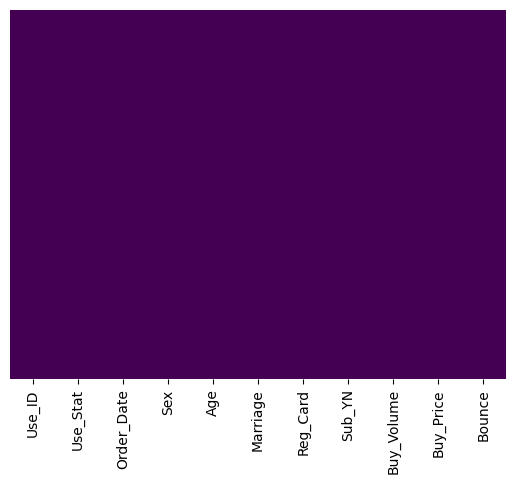

In [ ]:
sns.heatmap(grouped_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

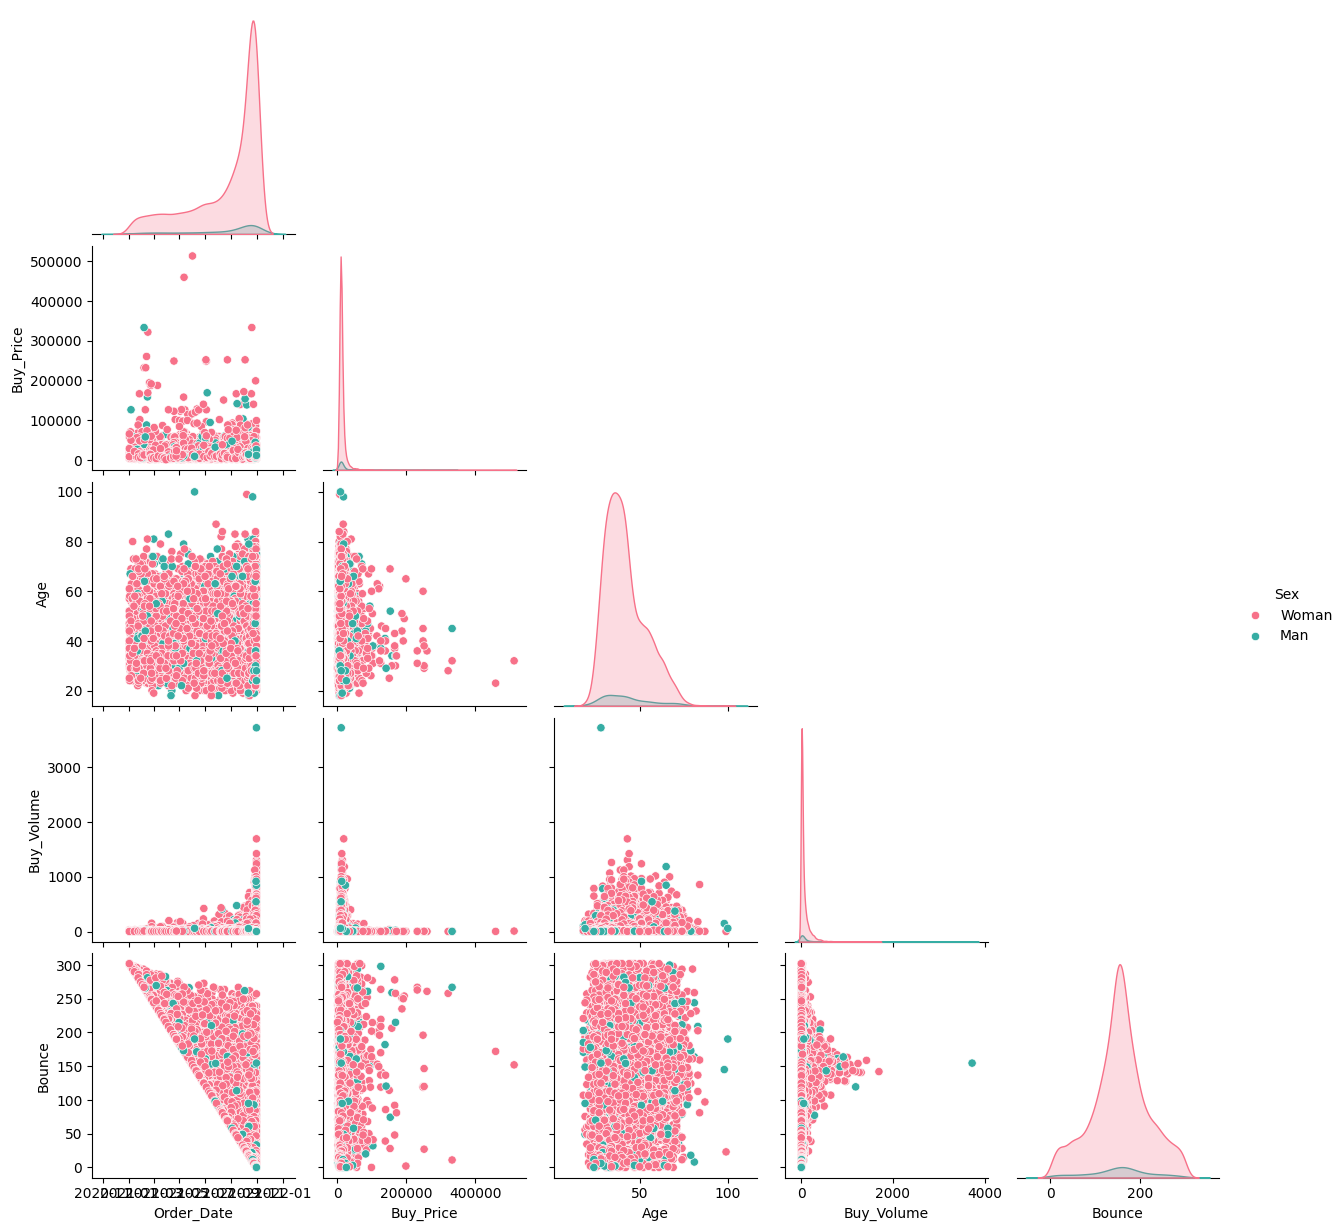

In [ ]:
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Sex',palette = 'husl', corner = True , data=grouped_data)
plt.show()

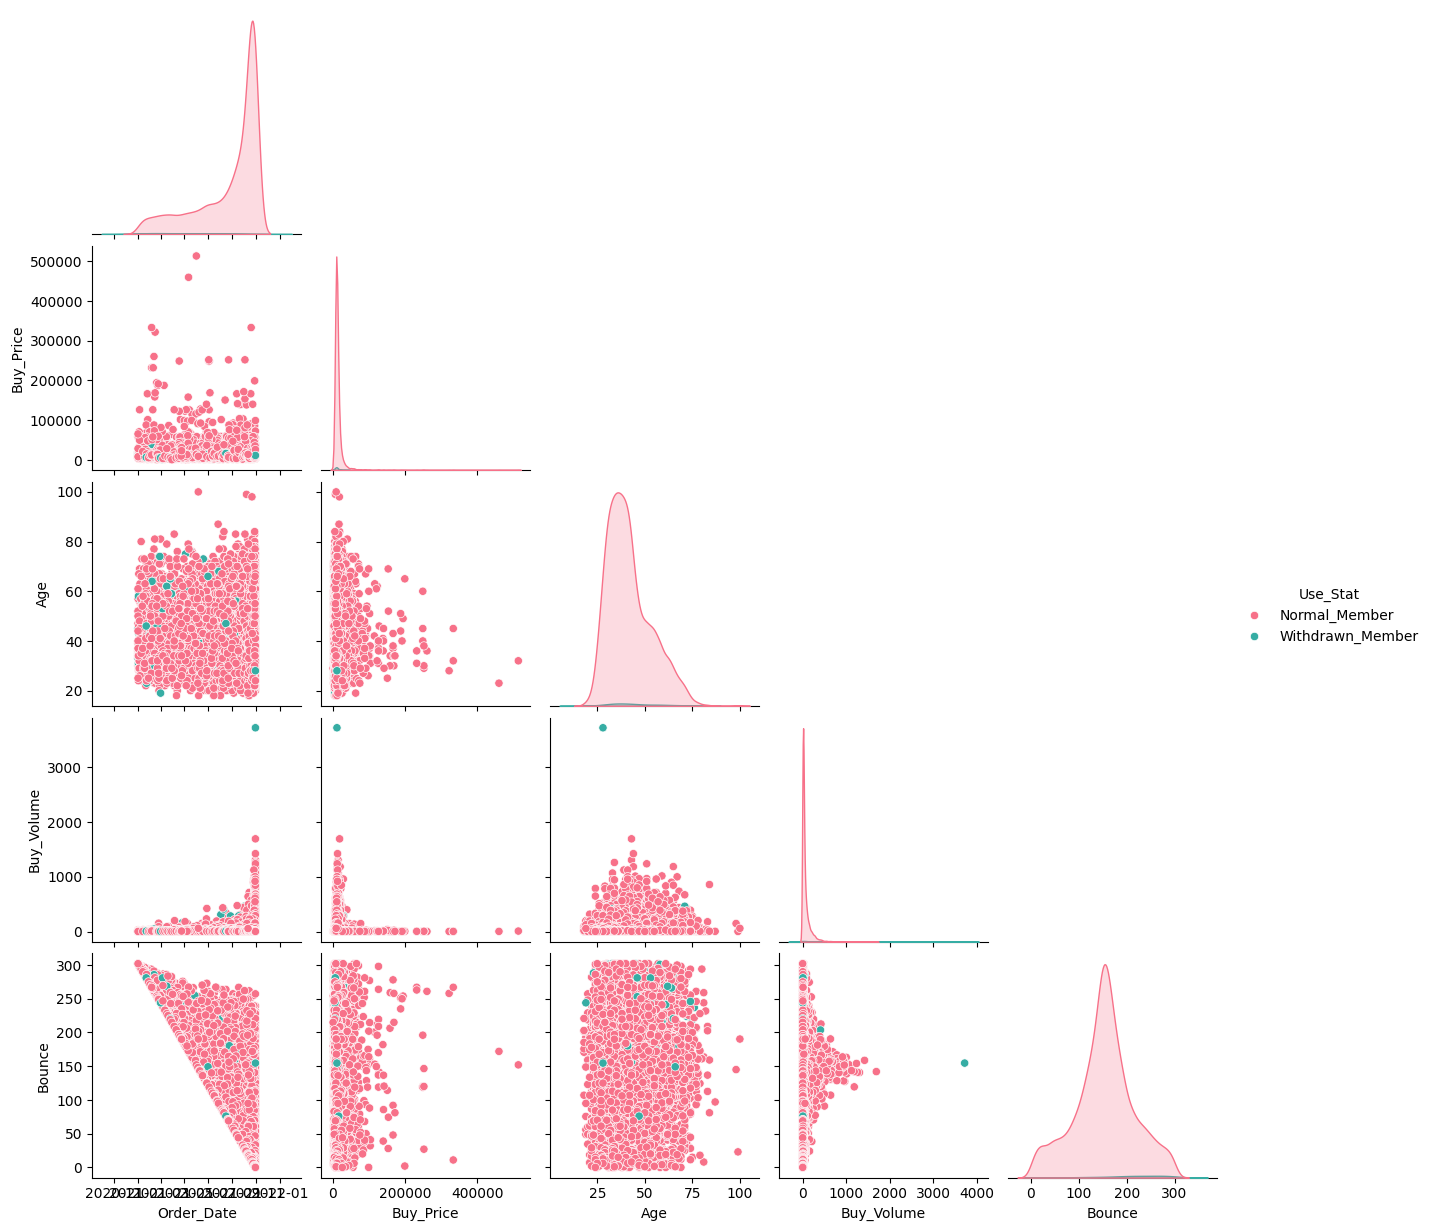

In [ ]:
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Use_Stat',palette = 'husl', corner = True , data=grouped_data)
plt.show()

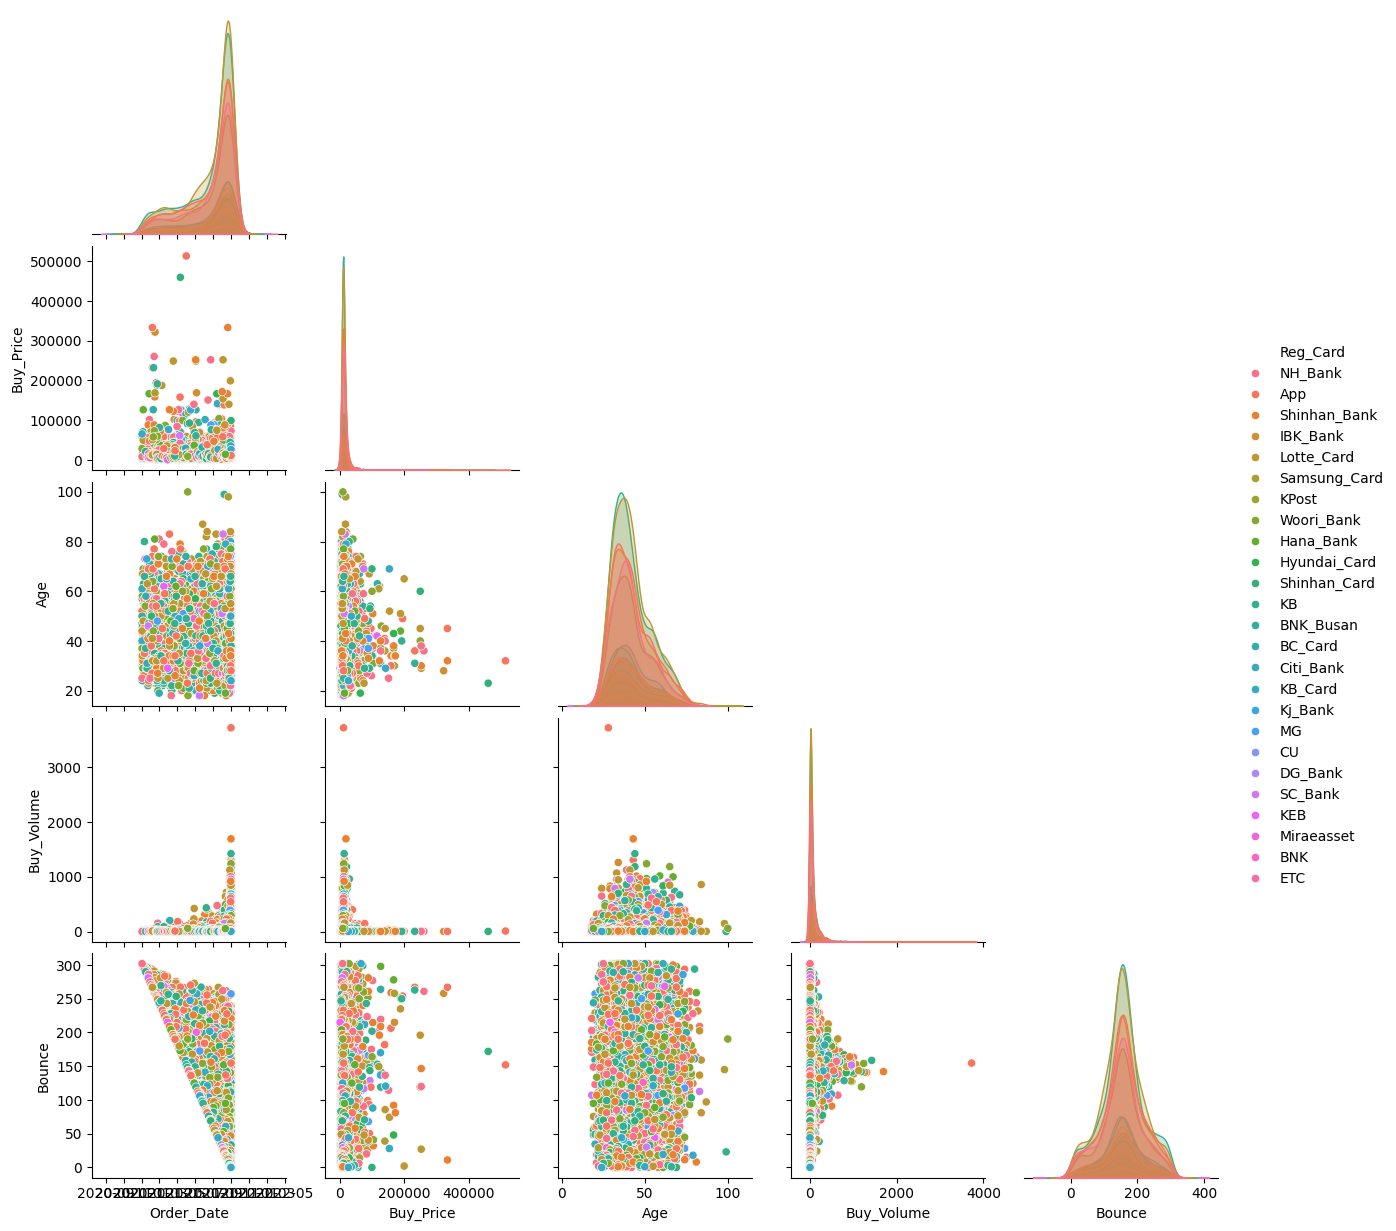

In [ ]:
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Reg_Card',palette = 'husl', corner = True , data=grouped_data)
plt.show()

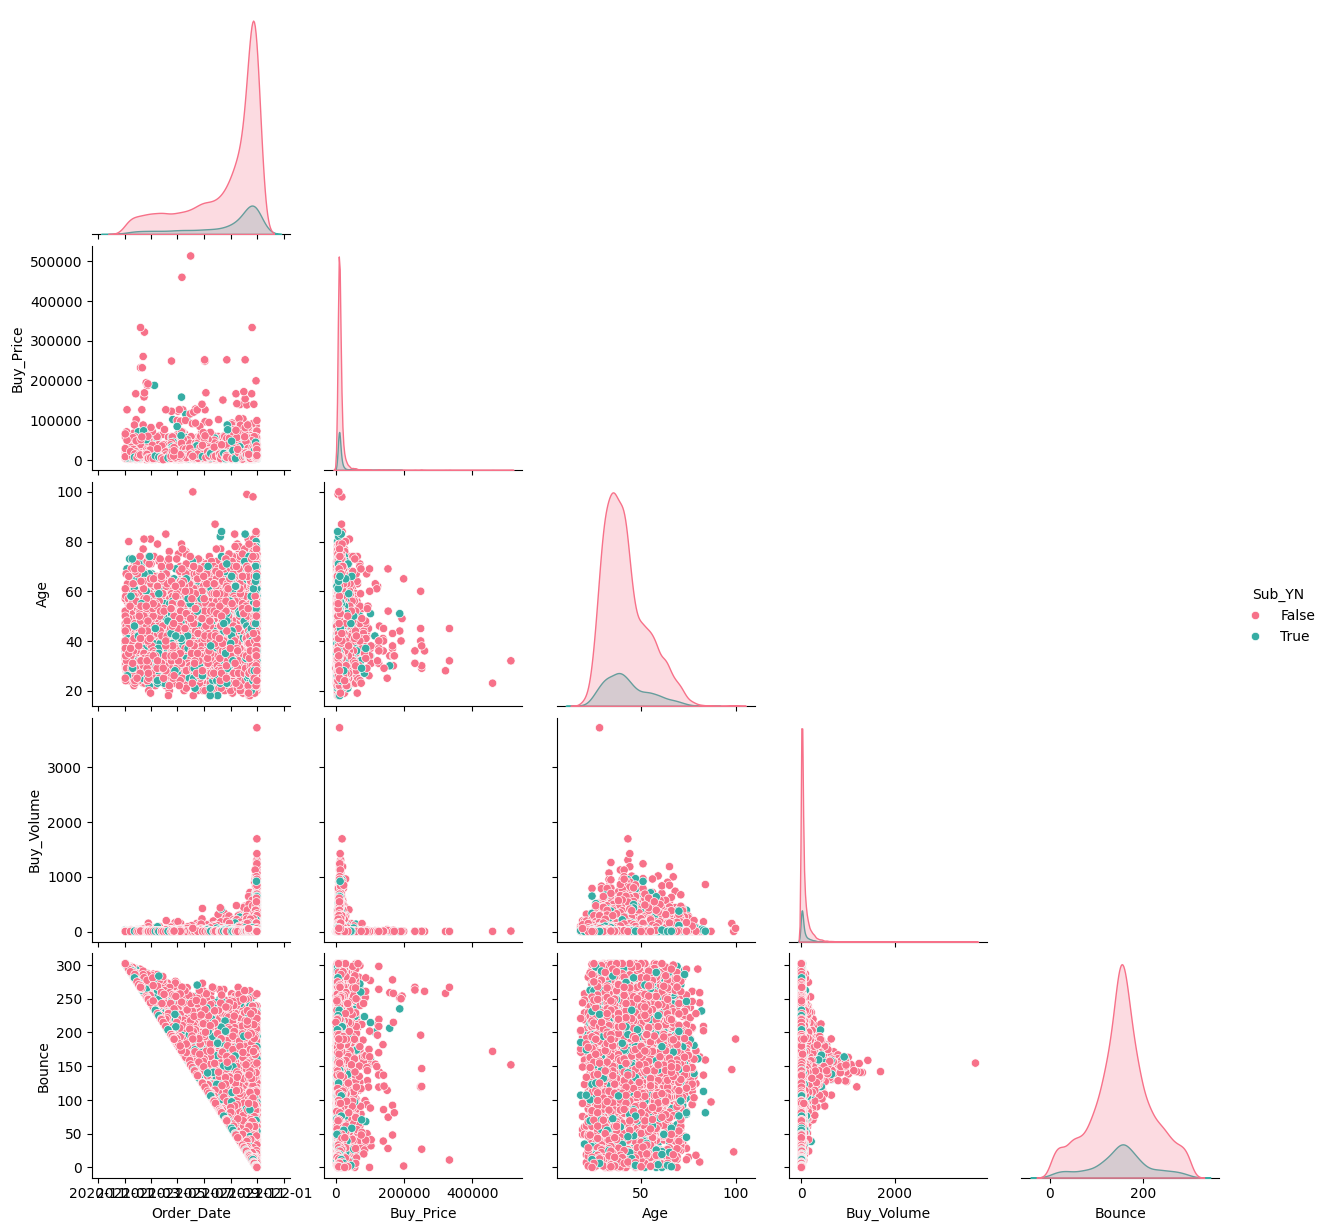

In [ ]:
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Sub_YN',palette = 'husl', corner = True , data=grouped_data)
plt.show()

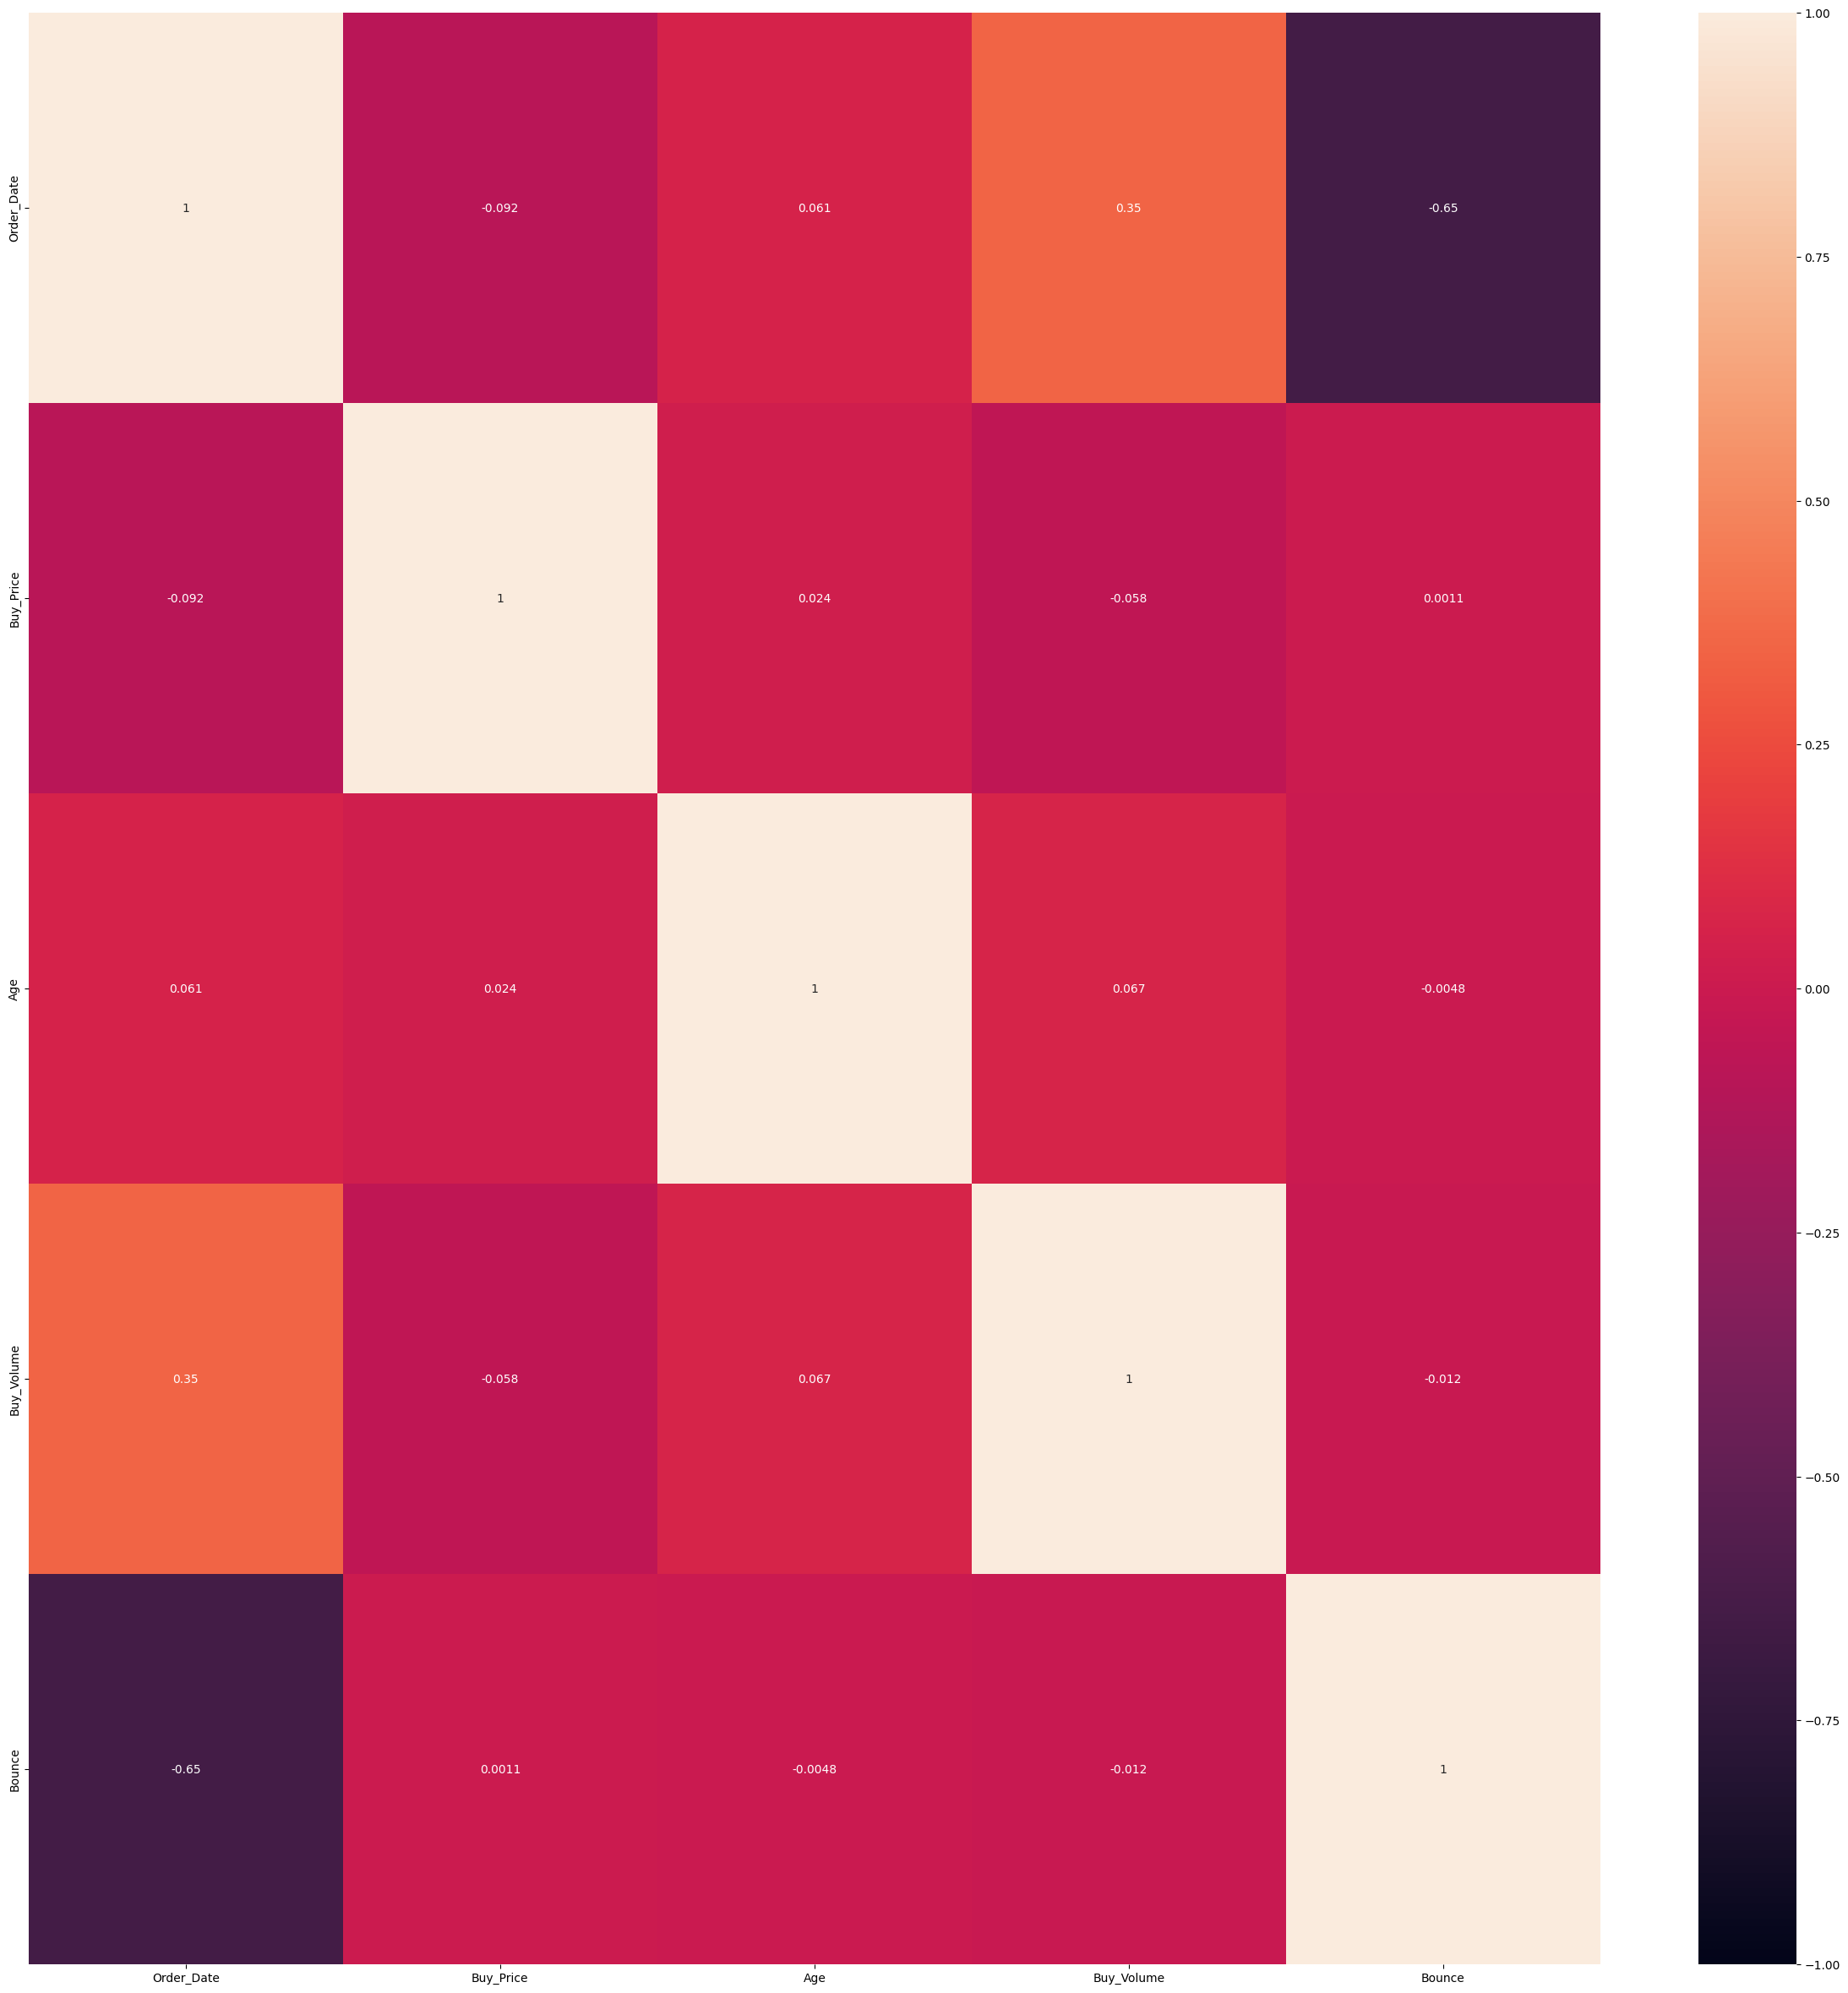

In [ ]:
plt.figure(figsize =(30,30))
sns.heatmap(grouped_data[['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce']].corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
# downsampling을 통한 분석
# 여성 데이터와 남성 데이터 추출
female_data = data[data['Sex'] == 'Woman']
male_data = data[data['Sex'] == 'Man']

# 여성 데이터 downsampling
female_downsampled = resample(female_data,
                                 replace=False,  # 중복 허용 안 함
                                 n_samples=len(male_data),  # 남성 데이터 수와 동일하게
                                 random_state=42)  # 랜덤 시드 고정

# female_downsampled를 데이터프레임으로 변환
female_downsampled = pd.DataFrame(female_downsampled, columns=female_data.columns)

# downsampling된 데이터와 남성 데이터 합치기
downsampled_data = pd.concat([female_downsampled, male_data])

In [ ]:
# downsampled_data의 각 컬럼별 데이터타입 확인
downsampled_data.dtypes
# downsampled_data의 'Order_Date'를 시계열 데이터로 변환
downsampled_data['Order_Date'] = pd.to_datetime(downsampled_data['Order_Date'])

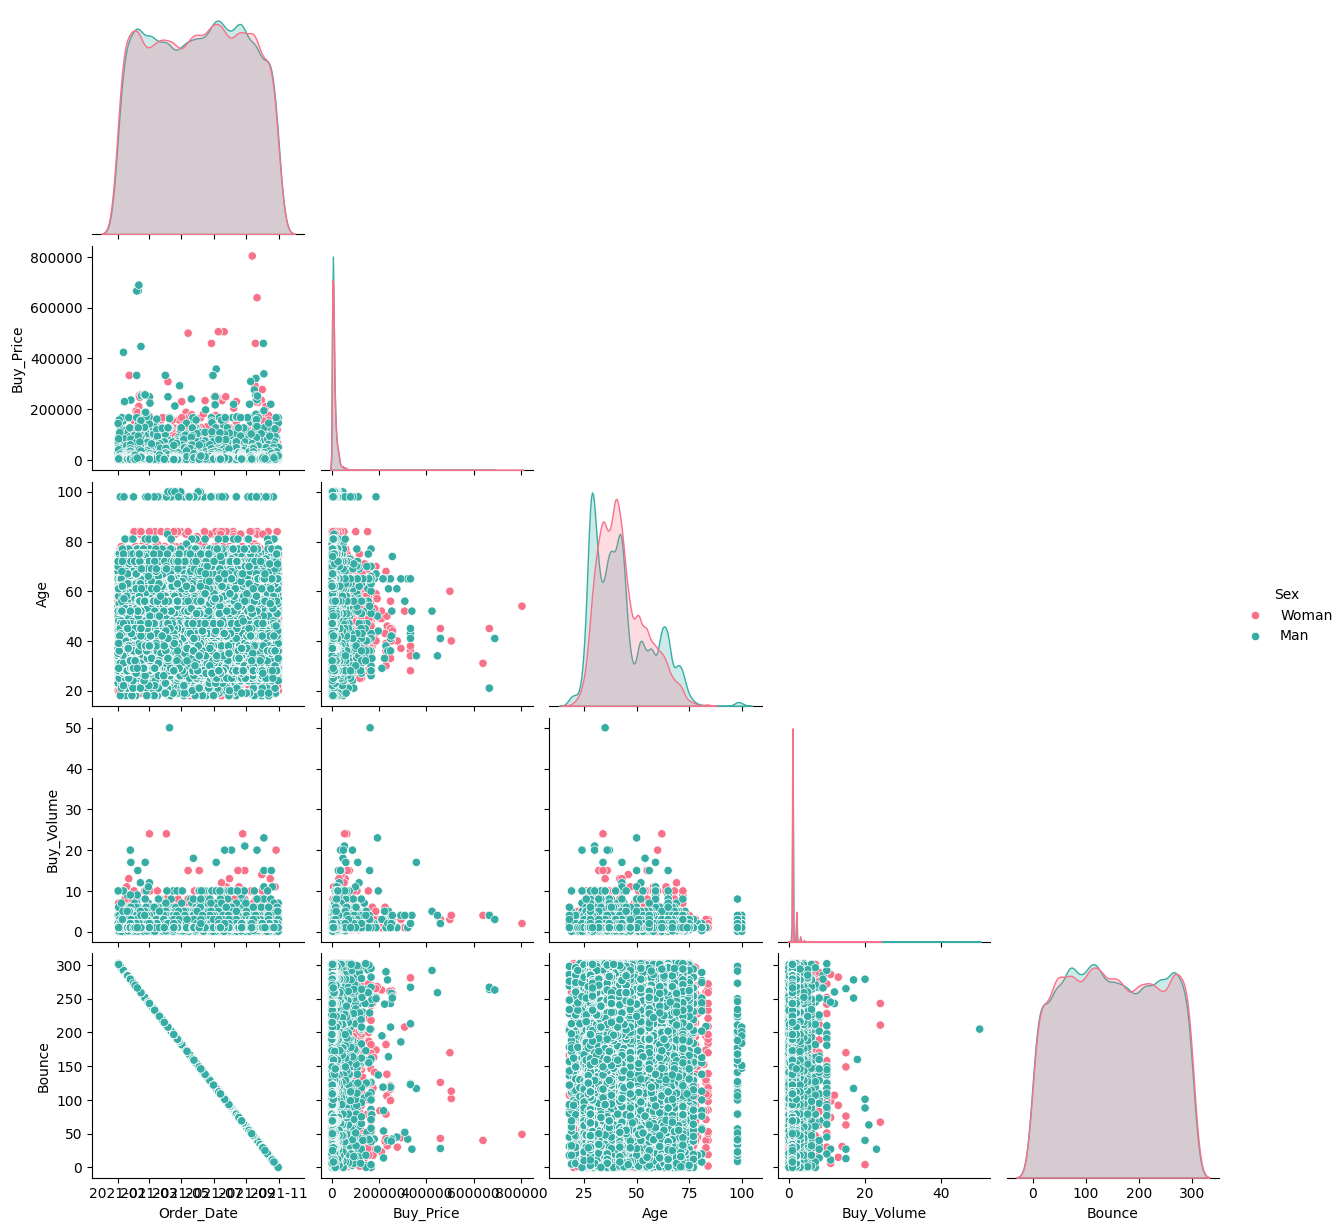

In [ ]:
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Sex',palette = 'husl', corner = True , data=downsampled_data)
plt.show()

In [ ]:
data.head()

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Deliv_Period,Bounce
0,1032097472,정상회원,1.0,7083,2021.1.2,여,39,기혼,우리은행,False,주문취소,302
1,1032097472,정상회원,1.0,29865,2021.1.2,여,39,기혼,우리은행,False,0.0,302
2,1032097472,정상회원,1.0,23164,2021.1.2,여,39,기혼,우리은행,False,1.0,302
3,369152832,정상회원,1.0,16655,2021.1.2,여,40,기혼,농협중앙회,False,1.0,302
4,1032097472,정상회원,1.0,8423,2021.1.2,여,39,기혼,우리은행,False,주문취소,302


In [ ]:
# data의 한글 항목을 영어로 번역해준다
# data의 Use_Stat에서 정상회원을 'Normal_Member'로 탈퇴를 'Withdrawn_Member'로 바꿔준다
data['Use_Stat'] = data['Use_Stat'].replace({'정상회원': 'Normal_Member', '탈퇴': 'Withdrawn_Member'})
# data의 Sex에서 '여'를 'Woman'으로 '남'을 'Man'으로 바꿔준다
data['Sex'] = data['Sex'].replace({'여': 'Woman', '남': 'Man'})
# data의 Marriage에서 '미혼'을 'Single'로 '기혼'을 'Married'로 '미응답'을 'Unresponsed'로 바꿔준다.
data['Marriage'] = data['Marriage'].replace({'미혼': 'Single', '기혼': 'Married', '미응답': 'Unresponsed'})
# data의 Marriage에서 '롯데카드'를 'Lotte_Card'로 '국민은행'을 'KB'로 '신한은행'을 'Shinhan_Bank'로 '연결앱결제'을 'App'으로 '농협중앙회'를 'NH_Bank'로 '우리은행'을 'Woori_Bank'로 '국민카드'을 'KB_Card'로 '신한카드'을 'Shinhan_Card'로 '하나은행'을 'Hana_Bank'로 '기업은행'을 'IBK_Bank'로 'BC카드'을 'BC_Card'로 '현대카드'을 'Hyundai_Card'로 '삼성카드'을 'Samsung_Card'로 '새마을금고'을 'MG'로 '부산은행'을 'BNK_Busan'로 '광주은행'을 'Kj_Bank'로 'Sc제일은행'을 'SC_Bank'로 '씨티은행'을 'Citi_Bank'로 '우체국'을 'KPost'로 '대구은행'을 'DG_Bank'로 '외환은행'을 'KEB'로 '신협중앙회'을 'CU'로 '미래에셋증권'을 'Miraeasset'로 '경남은행'을 'BNK'로 '기타'을 'ETC'로 바꿔준다.
data['Reg_Card'] = data['Reg_Card'].replace({'롯데카드': 'Lotte_Card', '국민은행': 'KB', '신한은행': 'Shinhan_Bank', '연결앱결제': 'App', '농협중앙회': 'NH_Bank', '우리은행': 'Woori_Bank', '국민카드': 'KB_Card', '신한카드': 'Shinhan_Card', '하나은행': 'Hana_Bank', '기업은행': 'IBK_Bank', 'BC카드': 'BC_Card', '현대카드': 'Hyundai_Card', '삼성카드': 'Samsung_Card', '새마을금고': 'MG', '부산은행': 'BNK_Busan', '광주은행': 'Kj_Bank', 'SC제일은행': 'SC_Bank', '씨티은행': 'Citi_Bank','우체국': 'KPost', '대구은행': 'DG_Bank', '외환은행': 'KEB', '신협중앙회': 'CU', '미래에셋증권': 'Miraeasset', '경남은행': 'BNK','기타': 'ETC'})

In [ ]:
data['Order_Date'] = pd.to_datetime(data['Order_Date'])

In [ ]:
data.dtypes

,0
Use_ID,int64
Use_Stat,object
Buy_Volume,float64
Buy_Price,int64
Order_Date,datetime64[ns]
Sex,object
Age,int64
Marriage,object
Reg_Card,object
Sub_YN,bool


In [ ]:
downsampled_data.head()

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Deliv_Period,Bounce,Age_Group,Total_Spending
131811,886566656,Normal_Member,1.0,6126,2021-05-04,Woman,55,Single,BC_Card,False,2.0,180,50s,6126.0
468356,743864384,Normal_Member,1.0,19144,2021-03-11,Woman,40,Unresponsed,KB,False,1.0,234,40s,19144.0
277570,852173120,Normal_Member,1.0,2489,2021-09-10,Woman,45,Married,Hyundai_Card,False,1.0,51,40s,2489.0
663508,1197520896,Normal_Member,1.0,21059,2021-10-01,Woman,60,Married,Shinhan_Bank,False,2.0,30,60s,21059.0
542283,318703040,Normal_Member,1.0,16273,2021-04-08,Woman,41,Married,App,True,1.0,206,40s,16273.0


In [ ]:
# data['Age']를 0~9세 : 0대, 10~19세 : 10대, 20~29세 : 20대, 30~39세 : 30대, 40~49세 : 40대, 50~59세 : 50대, 60~69세 : 60대, 70~79세 : 70대, 80세~ : 80대 이상으로 분류
def categorize_age(age):
  if 0 <= age <= 9:
    return '0s'
  elif 10 <= age <= 19:
    return '10s'
  elif 20 <= age <= 29:
    return '20s'
  elif 30 <= age <= 39:
    return '30s'
  elif 40 <= age <= 49:
    return '40s'
  elif 50 <= age <= 59:
    return '50s'
  elif 60 <= age <= 69:
    return '60s'
  elif 70 <= age <= 79:
    return '70s'
  else:
    return '80 or older'

data['Age_Group'] = data['Age'].apply(categorize_age)

In [ ]:
data['Age_Group'].value_counts()

,count
Age_Group,
30s,235132
40s,199492
50s,104050
20s,58599
60s,56411
70s,12968
80 or older,976
10s,481


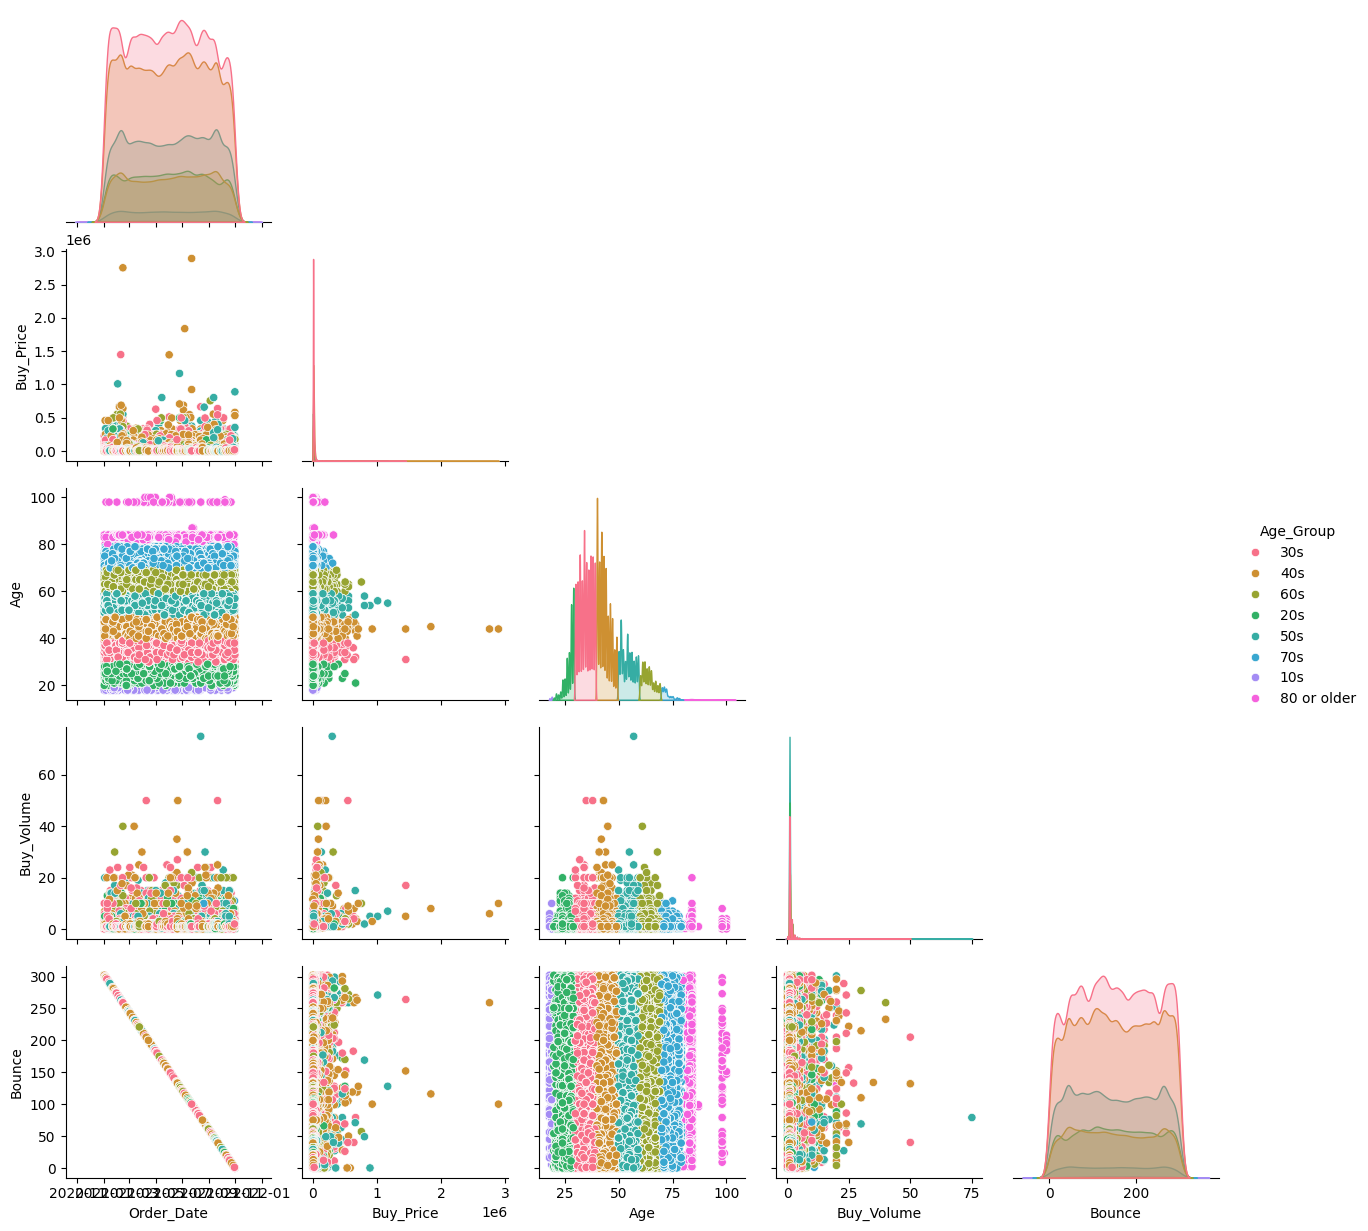

In [ ]:
# data['Age_Group']와 다른 컬럼들간의 비교
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Age_Group',palette = 'husl', corner = True , data=data)
plt.show()

In [ ]:
data['Total_Spending'] = data['Buy_Volume'] * data['Buy_Price']

In [ ]:
downsampled_data['Total_Spending'] = downsampled_data['Buy_Volume'] * downsampled_data['Buy_Price']

In [ ]:
total_spending_stats = data['Total_Spending'].describe()
print(total_spending_stats)

count    6.681090e+05
mean     1.642619e+04
std      9.114075e+04
min      8.520000e+01
25%      4.212000e+03
50%      8.423000e+03
75%      1.608100e+04
max      2.890766e+07
Name: Total_Spending, dtype: float64


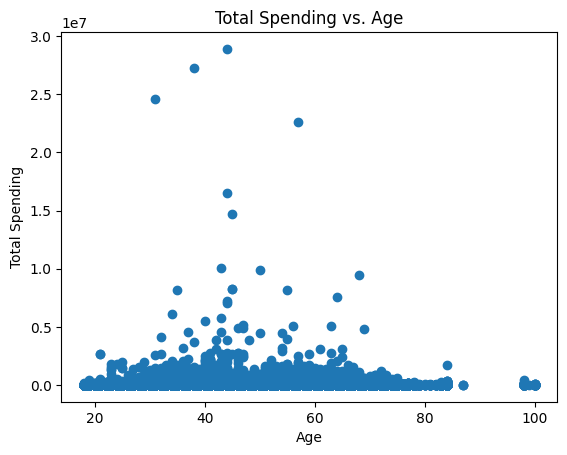

In [ ]:
plt.scatter(data['Age'], data['Total_Spending'])
plt.xlabel('Age')
plt.ylabel('Total Spending')
plt.title('Total Spending vs. Age')
plt.show()

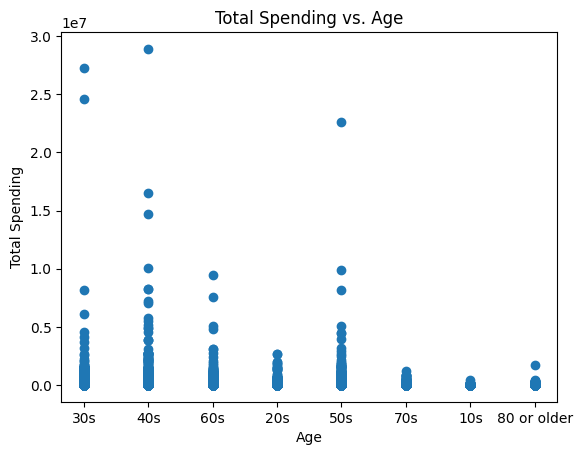

In [ ]:
plt.scatter(data['Age_Group'], data['Total_Spending'])
plt.xlabel('Age')
plt.ylabel('Total Spending')
plt.title('Total Spending vs. Age')
plt.show()

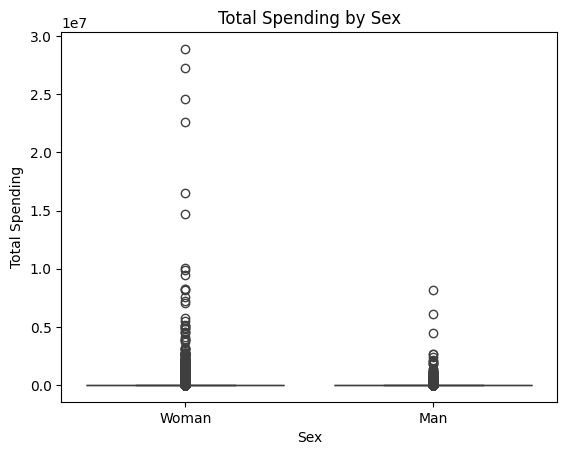

In [ ]:
sns.boxplot(x='Sex', y='Total_Spending', data=data)
plt.xlabel('Sex')
plt.ylabel('Total Spending')
plt.title('Total Spending by Sex')
plt.show()

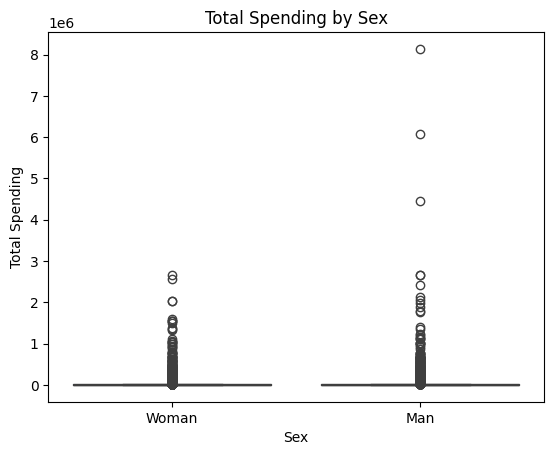

In [ ]:
sns.boxplot(x='Sex', y='Total_Spending', data=downsampled_data)
plt.xlabel('Sex')
plt.ylabel('Total Spending')
plt.title('Total Spending by Sex')
plt.show()

In [ ]:
# 수치형 변수들간 상관계수 분석
corr_matrix = data[['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce','Total_Spending']].corr()
print(corr_matrix)

                Order_Date  Buy_Price       Age  Buy_Volume    Bounce  \
Order_Date        1.000000   0.007085  0.011434    0.009955 -1.000000   
Buy_Price         0.007085   1.000000  0.037736    0.197146 -0.007085   
Age               0.011434   0.037736  1.000000    0.035102 -0.011434   
Buy_Volume        0.009955   0.197146  0.035102    1.000000 -0.009955   
Bounce           -1.000000  -0.007085 -0.011434   -0.009955  1.000000   
Total_Spending    0.003768   0.592038  0.017366    0.433603 -0.003768   

                Total_Spending  
Order_Date            0.003768  
Buy_Price             0.592038  
Age                   0.017366  
Buy_Volume            0.433603  
Bounce               -0.003768  
Total_Spending        1.000000  


In [ ]:
# 수치형 변수들간 상관계수 분석
corr_matrix = downsampled_data[['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce','Total_Spending']].corr()
print(corr_matrix)

                Order_Date  Buy_Price       Age  Buy_Volume    Bounce  \
Order_Date        1.000000   0.007125  0.022044    0.012605 -1.000000   
Buy_Price         0.007125   1.000000  0.040820    0.201568 -0.007125   
Age               0.022044   0.040820  1.000000    0.031032 -0.022044   
Buy_Volume        0.012605   0.201568  0.031032    1.000000 -0.012605   
Bounce           -1.000000  -0.007125 -0.022044   -0.012605  1.000000   
Total_Spending    0.002909   0.634047  0.021214    0.567896 -0.002909   

                Total_Spending  
Order_Date            0.002909  
Buy_Price             0.634047  
Age                   0.021214  
Buy_Volume            0.567896  
Bounce               -0.002909  
Total_Spending        1.000000  


In [ ]:
downsampled_data_male_spending = downsampled_data[downsampled_data['Sex'] == 'Man']['Total_Spending']
downsampled_data_female_spending = downsampled_data[downsampled_data['Sex'] == 'Woman']['Total_Spending']
t_statistic, p_value = stats.ttest_ind(male_spending, female_spending)
print(f"T-statistic: {t_statistic}, p-value: {p_value}")

T-statistic: 1.2311387734590868, p-value: 0.21827139938873327


In [ ]:
male_spending = data[data['Sex'] == 'Man']['Total_Spending']
female_spending = data[data['Sex'] == 'Woman']['Total_Spending']
t_statistic, p_value = stats.ttest_ind(male_spending, female_spending)
print(f"T-statistic: {t_statistic}, p-value: {p_value}")

T-statistic: 1.2311387734590868, p-value: 0.21827139938873327


In [ ]:
# Example using Linear Regression
X = data[['Age', 'Bounce']]  # Independent variables
y = data['Total_Spending']  # Dependent variable
model = LinearRegression()
model.fit(X, y)
print(model.coef_)  # Coefficients of the regression model

[138.71478329  -3.74163956]


In [ ]:
crosstab, res = rp.crosstab(data['Bounce'], data['Sex'], test='chi-square')
cramers_v = res['results'][2]
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.0549


In [ ]:
crosstab, res = rp.crosstab(data['Use_Stat'], data['Sex'], test='chi-square')
cramers_v = res['results'][2]
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.1739


In [ ]:
crosstab, res = rp.crosstab(data['Buy_Volume'], data['Sex'], test='chi-square')
cramers_v = res['results'][2]
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.0169


In [ ]:
crosstab, res = rp.crosstab(data['Total_Spending'], data['Sex'], test='chi-square')
cramers_v = res['results'][2]
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.1369


In [ ]:
crosstab, res = rp.crosstab(data['Buy_Price'], data['Sex'], test='chi-square')
cramers_v = res['results'][2]
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.1237


In [ ]:
crosstab, res = rp.crosstab(data['Sub_YN'], data['Sex'], test='chi-square')
cramers_v = res['results'][2]
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.0178


In [ ]:
correlation, p_value = stats.pointbiserialr(data['Bounce'], data['Total_Spending'])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")

Point-Biserial Correlation: -0.003768009820773747, p-value: 0.0020707109189325485


In [ ]:
correlation, p_value = stats.pointbiserialr(data['Buy_Volume'], data['Total_Spending'])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")

Point-Biserial Correlation: 0.4336028743871873, p-value: 0.0


In [ ]:
correlation, p_value = stats.pointbiserialr(data['Buy_Price'], data['Total_Spending'])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")

Point-Biserial Correlation: 0.5920375862210538, p-value: 0.0


In [ ]:
correlation, p_value = stats.pointbiserialr(data['Age'], data['Total_Spending'])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")

Point-Biserial Correlation: 0.017366408506274078, p-value: 9.701010754685036e-46


In [ ]:
correlation = data['Buy_Volume'].corr(data['Buy_Price'])
print(f"Pearson Correlation: {correlation}")

Pearson Correlation: 0.19714641262036006


In [ ]:
correlation = data['Buy_Volume'].corr(data['Total_Spending'])
print(f"Pearson Correlation: {correlation}")

Pearson Correlation: 0.4336028743871976


In [ ]:
# data['Bounce']가 30 이상일 경우, 1로 data['Bounce_Rate']에 저장. 만약 아니라면 0으로 저장
data.loc[data['Bounce'] >= 30, 'Bounce_Rate'] = 1
data.loc[data['Bounce'] < 30, 'Bounce_Rate'] = 0

In [ ]:
data

,Use_ID,Use_Stat,Buy_Volume,Buy_Price,Order_Date,Sex,Age,Marriage,Reg_Card,Sub_YN,Deliv_Period,Bounce,Age_Group,Total_Spending,Bounce_Rate
0,1032097472,Normal_Member,1.0,7083,2021-01-02,Woman,39,Married,Woori_Bank,False,주문취소,302,30s,7083.0,1.0
1,1032097472,Normal_Member,1.0,29865,2021-01-02,Woman,39,Married,Woori_Bank,False,0.0,302,30s,29865.0,1.0
2,1032097472,Normal_Member,1.0,23164,2021-01-02,Woman,39,Married,Woori_Bank,False,1.0,302,30s,23164.0,1.0
3,369152832,Normal_Member,1.0,16655,2021-01-02,Woman,40,Married,NH_Bank,False,1.0,302,40s,16655.0,1.0
4,1032097472,Normal_Member,1.0,8423,2021-01-02,Woman,39,Married,Woori_Bank,False,주문취소,302,30s,8423.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668106,1523874368,Normal_Member,1.0,166554,2021-10-19,Woman,38,Unresponsed,Shinhan_Bank,False,0.0,12,30s,166554.0,0.0
668107,402835520,Normal_Member,1.0,12635,2021-10-23,Man,42,Married,Woori_Bank,False,1.0,8,40s,12635.0,0.0
668108,402835520,Normal_Member,1.0,7849,2021-10-23,Man,42,Married,Woori_Bank,False,0.0,8,40s,7849.0,0.0
668109,1544381312,Normal_Member,1.0,7275,2021-10-27,Woman,45,Married,Hyundai_Card,False,1.0,4,40s,7275.0,0.0


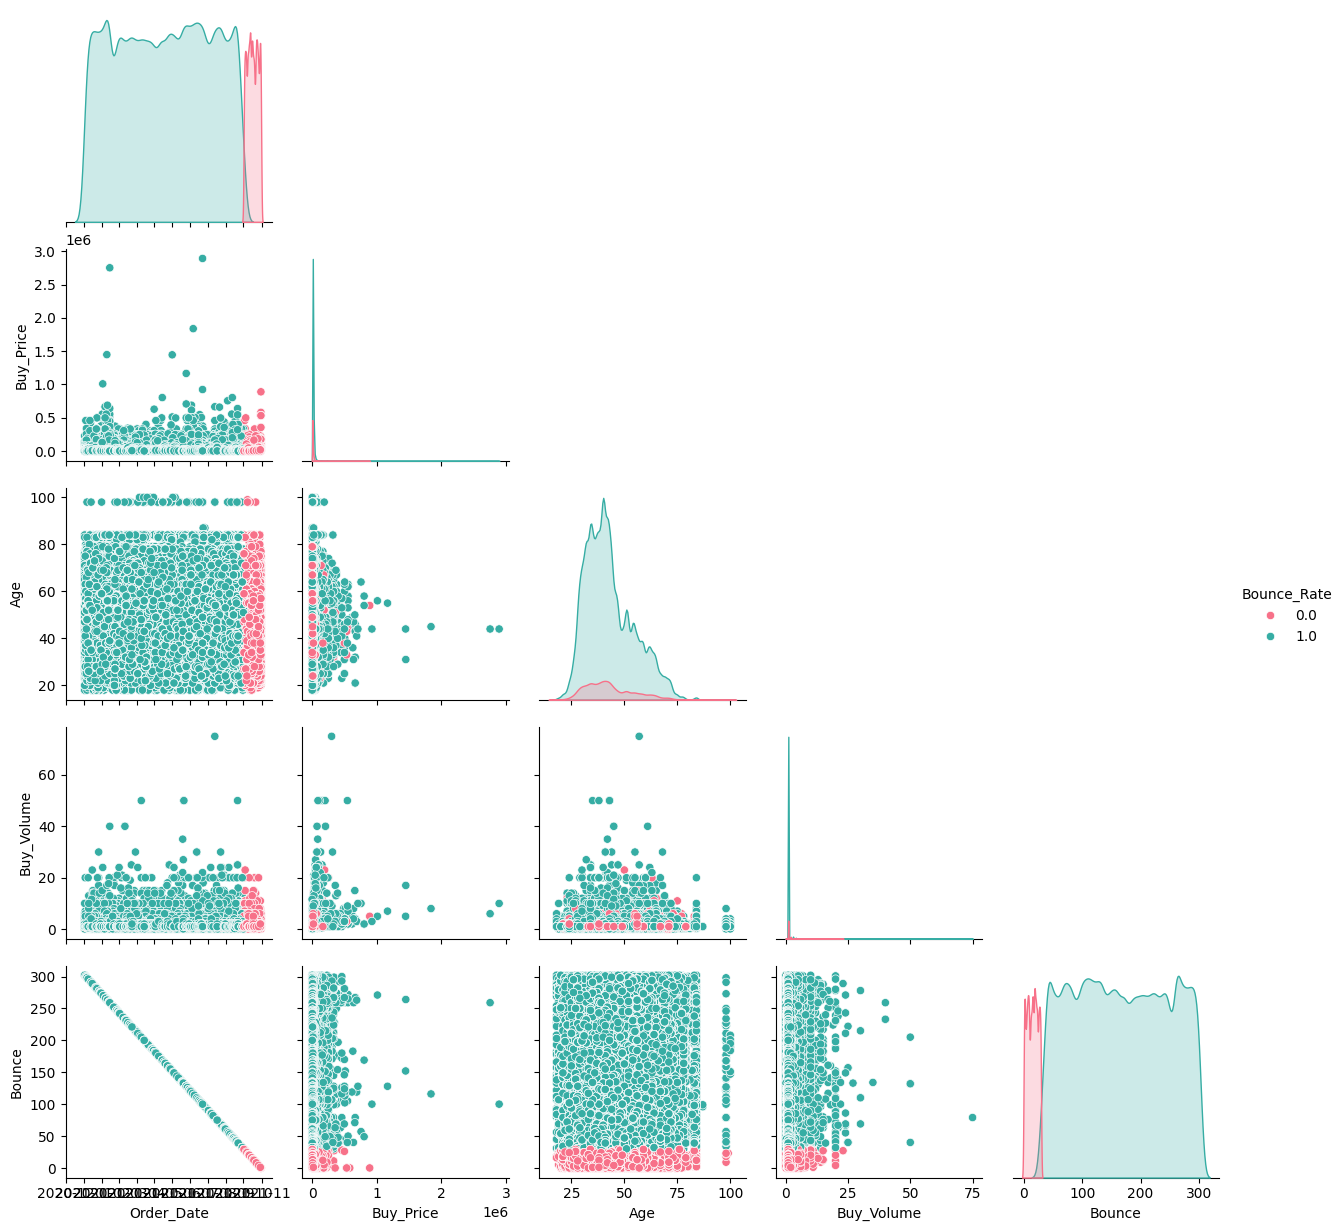

In [ ]:
# data['Bounce_Rate']와 다른 컬럼들간의 비교
# 이탈 : 1, 잔존 : 0
sns.pairplot(vars=['Order_Date', 'Buy_Price', 'Age', 'Buy_Volume','Bounce'], hue='Bounce_Rate',palette = 'husl', corner = True , data=data)
plt.show()